In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps

import sys
import yaml

import qubic
from qubic.lib.Instrument.Qacquisition import QubicDualBand

from qubic.lib.MapMaking.Qmaps import InputMaps
from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import *



comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline

In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)

In [4]:
atm.qubic_dict

{'debug': False,
 'config': 'FI',
 'filter_nu': 150000000000.0,
 'filter_relative_bandwidth': 0.25,
 'beam_shape': 'gaussian',
 'MultiBand': True,
 'nf_sub': 8,
 'center_detector': False,
 'psd': None,
 'bandwidth': None,
 'twosided': None,
 'sigma': None,
 'detector_nep': 4.7e-17,
 'detector_fknee': 0,
 'detector_fslope': 1,
 'detector_ncorr': 10,
 'detector_ngrids': 1,
 'detector_tau': 0.01,
 'polarizer': True,
 'synthbeam_fraction': 0.99,
 'synthbeam_kmax': 1,
 'synthbeam_peak150_fwhm': 0.39268176,
 'ripples': False,
 'nripples': 0,
 'focal_length': 0.3,
 'optics': 'CalQubic_Optics_v3_CC_FFF.txt',
 'primbeam': 'CalQubic_PrimBeam_v2.fits',
 'detarray': 'CalQubic_DetArray_v4_CC.fits',
 'hornarray': 'CalQubic_HornArray_CC.fits',
 'synthbeam': 'CalQubic_Synthbeam_Analytical_220_FI.fits',
 'nside': 128,
 'kind': 'IQU',
 'absolute': False,
 'temperature': 2.7255,
 'summer': False,
 'RA_center': 0,
 'DEC_center': -57,
 'period': 1,
 'date_obs': '2016-01-01 00:00:00',
 'latitude': -24.18333

Text(0.5, 1.0, 'Atmospheric Absorption Spectrum')

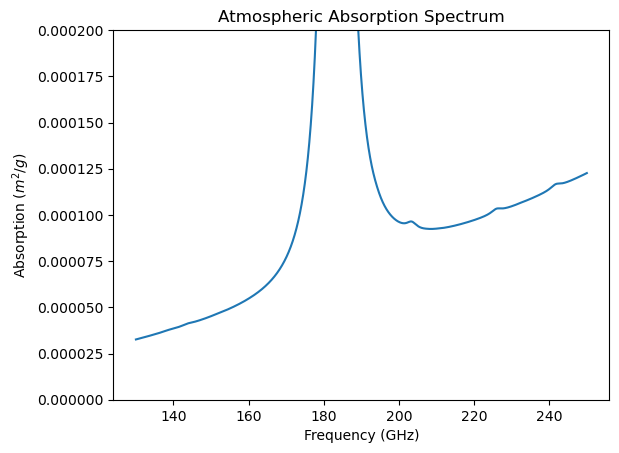

In [5]:
# Import the atm absorption spectrum
abs_spectrum = atm.absorption_spectrum()

plt.plot(atm.integration_frequencies, abs_spectrum)
plt.ylim(0, 0.0002)
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'Absorption ($m^{2}/g$)')
plt.title("Atmospheric Absorption Spectrum")

(8, 500, 500)


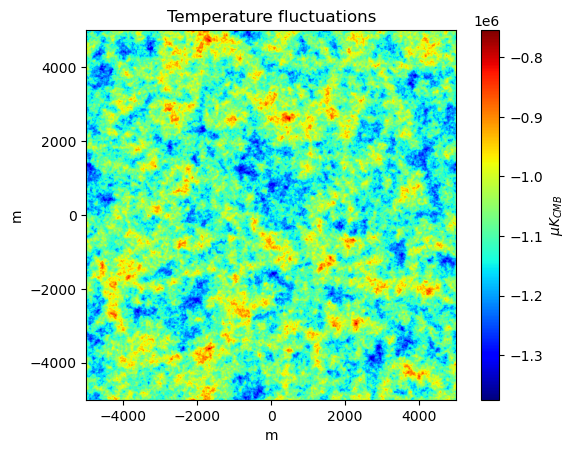

In [6]:
# Import the atm temperature maps
atm_maps = atm.get_temp_maps(atm.rho_map)
print(atm_maps.shape)
plt.imshow(atm_maps[0], cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Temperature fluctuations')
plt.xlabel('m')
plt.ylabel('m')
plt.colorbar(label=r'$\mu K_{CMB}$')

# Import the atm integrated absorption spectrum
integrated_abs_spectrum, frequencies = atm.integrated_absorption_spectrum()

Text(0.5, 1.0, 'Integrated absorption spectrum')

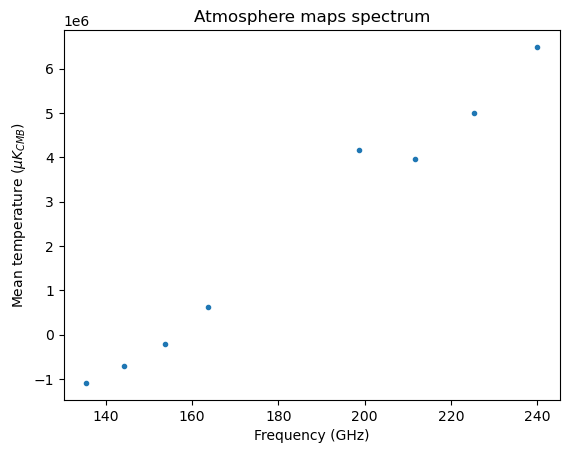

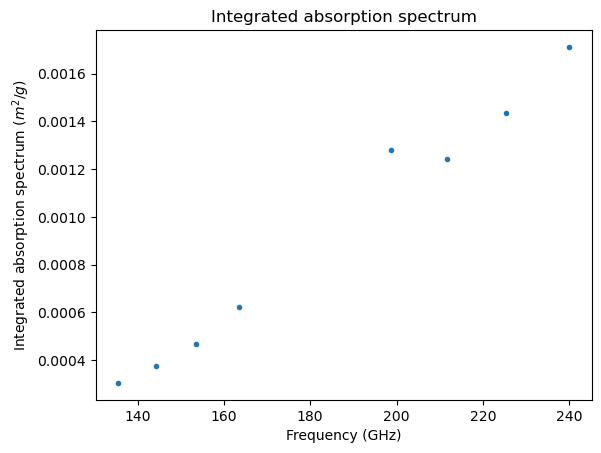

In [7]:
mean_atm_maps = []
for i in range(atm_maps.shape[0]):
    mean_atm_maps.append(np.mean(atm_maps[i]))
plt.figure()
plt.plot(frequencies, mean_atm_maps, '.')
plt.title('Atmosphere maps spectrum')
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'Mean temperature ($\mu K_{CMB}$)')
plt.figure()
plt.plot(frequencies, integrated_abs_spectrum, '.')
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'Integrated absorption spectrum ($m^{2}/g$)')
plt.title('Integrated absorption spectrum')

Text(0.5, 1.0, 'Atmosphere temperature map at 135.51 GHz')

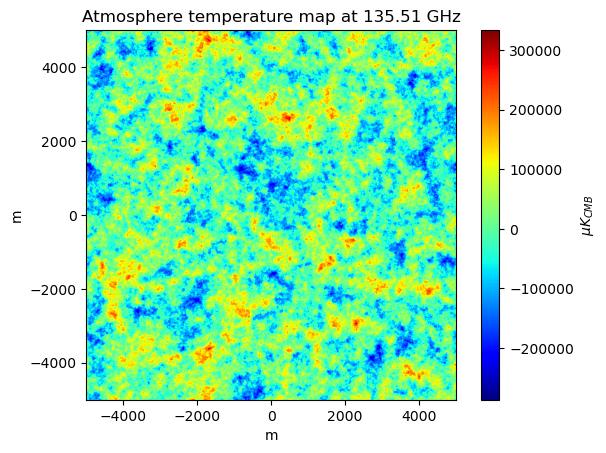

In [8]:
for i in range(len(frequencies)):
    atm_maps[i] -= np.mean(atm_maps[i])
    
index_nu = 0
plt.imshow(atm_maps[index_nu], cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.colorbar(label=r'$µK_{CMB}$')
plt.xlabel('m')
plt.ylabel('m')
plt.title('Atmosphere temperature map at {:.2f} GHz'.format(frequencies[index_nu]))

In [9]:
atm.get_healpy_atm_maps_2d(atm_maps).shape

(8, 196608)

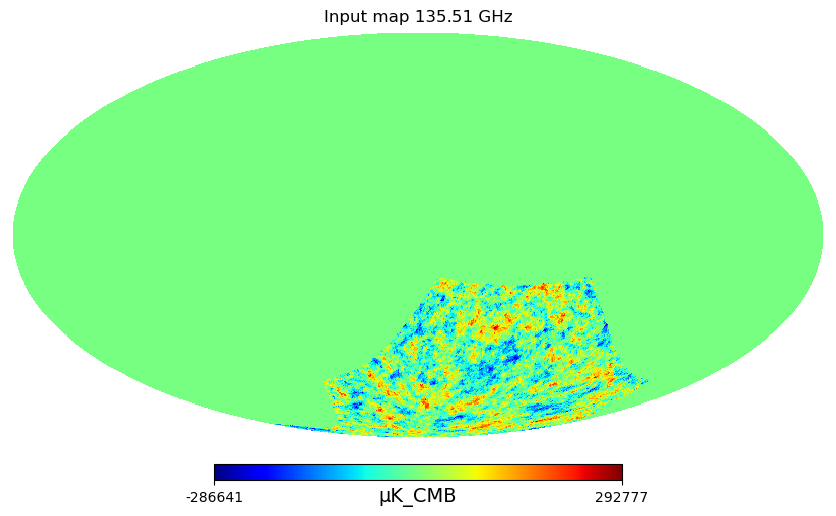

In [10]:
# Build input maps : Atmsophere (only for I map)
# I substract the mean value to each map to keep only the temperature fluctuations
input_maps = np.zeros((len(frequencies), hp.nside2npix(params['nside']), 3))

index = np.where(atm.get_healpy_atm_maps_2d(atm_maps)[0, :] != 0)
input_maps[:, index, 0] += atm.get_healpy_atm_maps_2d(atm_maps)[:, index]

hp.mollview(input_maps[index_nu, :, 0] ,cmap='jet', unit='µK_CMB', title='Input map {:.2f} GHz'.format(frequencies[index_nu]))

(2, 196608, 3)
[149.2645495  218.92133926]


(130.0, 250.0)

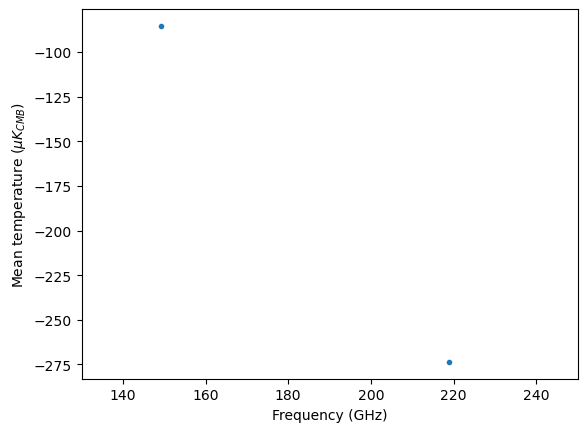

In [11]:
# Compute the Nrec true maps from the Nsub maps
true_maps = np.zeros((params['nrec'], 12*params['nside']**2, 3))
true_frequencies = np.zeros(params['nrec'])
fsub = int(params['nsub_in'] / params['nrec'])

# Build the reconstructed maps and frequency by taking the mean inside each reconstructed frequency band
for i in range(params['nrec']):
    true_maps[i, :, :] = np.mean(input_maps[i*fsub:(i+1)*fsub, :, :], axis=0)
    true_frequencies[i] = np.mean(frequencies[i*fsub:(i+1)*fsub])
print(true_maps.shape) 
print(true_frequencies)   
plt.plot(true_frequencies, np.mean(true_maps, axis=1)[..., 0], '.')
plt.ylabel(r'Mean temperature ($\mu K_{CMB}$)')
plt.xlabel('Frequency (GHz)')
plt.xlim(130, 250)

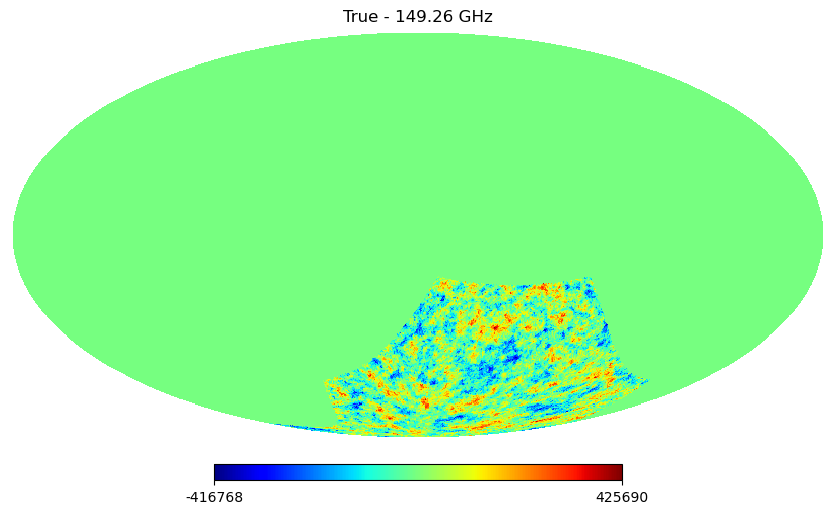

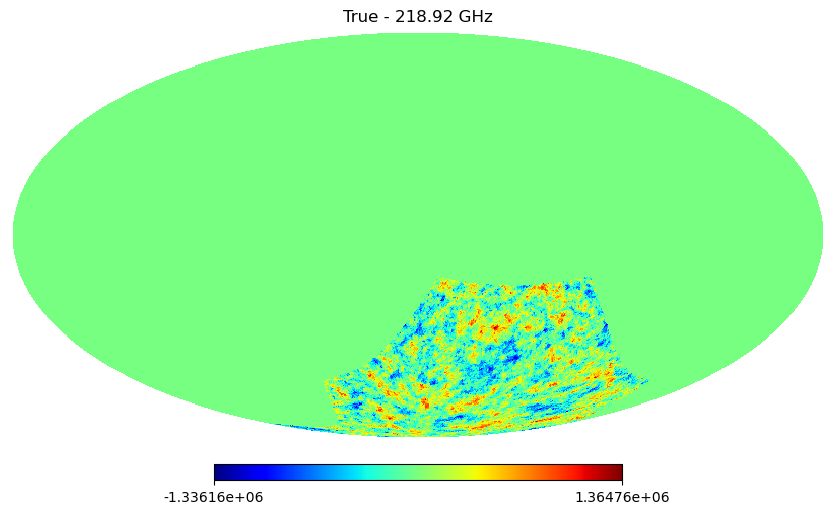

In [12]:
# Plot all the true maps
for inu in range(len(true_frequencies)):
    hp.mollview(true_maps[inu, :, 0], cmap='jet', title='True - {:.2f} GHz'.format(true_frequencies[inu]))

# Map-making

In [13]:
# Build the QUBIC operators
H_tod = QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nsub_in']).get_operator()
tod = H_tod(input_maps).ravel()
del H_tod

Qacq = QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nrec'])

You asked 5000 pointings with repeat strategy so I will provide 1666 pointings repeated 3 times.
Info DESKTOP-5T6UOML: Allocating (4958016,9) elements = 680.8798828125 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (4958016,9) elements = 680.8798828125 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (4958016,9) elements = 680.8798828125 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (4958016,9) elements = 680.8798828125 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (4958016,9) elements = 680.8798828125 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (4958016,9) elements = 680.8798828125 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (4958016,9) elements = 680.8798828125 MiB in FSRRotation3dMatrix.__init__.
Info DESKTOP-5T6UOML: Allocating (4958016,9) elements = 680.8798828125 MiB in FSRRotation3dMatrix.__init__.
You asked 5000 pointings with repeat st

In [14]:
invN = Qacq.get_invntt_operator()

if params['nrec']==2:
    H_rec = Qacq.get_operator().operands[1]
else:
    H_rec = Qacq.get_operator()

R = ReshapeOperator(H_rec.shapeout, invN.shapein)
H_rec = R*H_rec

In [15]:
coverage = Qacq.coverage

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

In [16]:
# Print Operators' shape
print('H_rec', H_rec.shapein, H_rec.shapeout)
print("invN", invN.shapein, invN.shapeout)
print("TOD", tod.shape)

H_rec (2, 196608, 3) (1984, 4998)
invN (1984, 4998) (1984, 4998)
TOD (9916032,)


In [17]:
# Build PCG
R = ReshapeOperator(tod.shape, invN.shapein)
A = H_rec.T * invN * H_rec
b = H_rec.T * invN * R(tod)
x0 = true_maps*0

In [18]:
if params['nrec'] != 2:
    print("Number of Physical Bands :", len(H_rec.operands)) # operands[0] = 150 GHz / operands[1] = 220 GHz
    print("Number of Reconstructed Sub-Bands within each physical Bands :", len(H_rec.operands[0].operands))
    print("Number of Sub-Bands within each reconstructed bands :", len(H_rec.operands[0].operands[0].operands)) # operands[0] = 150 GHz / operands[1] = 220 GHz
else:
    H_rec = H_rec.operands[1]
    print("Number of Reconstructed Sub-Bands within each physical Bands :", len(H_rec.operands))
    print("Number of Sub-Bands within each reconstructed bands :", len(H_rec.operands[0].operands))

Number of Reconstructed Sub-Bands within each physical Bands : 2
Number of Sub-Bands within each reconstructed bands : 4


Note about preconditioner: stacked_dptdp_inv should have the shape (Nrec, Npix). But, we can compute that from H, which contains Nsub acquisition operators. In the next cell, I am using only the first Nrec operators rather than Nsub, because I don't know how to reduce them.
I tried to compute it with another H which had exactly Nrec sub-operators, but it didn't work.
We need to find a solution to this problem.

In [19]:
# Build Preconditionner
stacked_dptdp_inv = np.zeros((params['nrec'],12*params['nside']**2))
no_det = 992

nrec_cpt = 0

### Loop on Focal Plane
for i_fp in range(2):
    ### Loop on Reconstructed Bands
    for j_nrec in range(int(params["nrec"]/2)):


        ### Loop on Frequency Bands within each reconstructed band
        
        print("Focal plane :", i_fp, "Reconstructed band :", j_nrec)

        ### Extract Operators
        if params['nrec'] == 2:
            H_single = H_rec.operands[i_fp].operands[j_nrec]
        else:
            H_single = H_rec.operands[0].operands[i_fp].operands[j_nrec]
        D = H_single.operands[1]
        P = H_single.operands[-1]
        sh = P.matrix.data.index.shape

        ### Compute the map P^t P
        point_per_det = int(sh[0] / no_det)
        mapPtP_perdet_seq = np.zeros((no_det, 12 * params['nside']**2))
        sample_ranges = [(det * point_per_det, (det + 1) * point_per_det) for det in range(no_det)]
        for det, (start, end) in enumerate(sample_ranges):
            indices = P.matrix.data.index[start:end, :]  
            weights = P.matrix.data.r11[start:end, :]
            flat_indices = indices.ravel()
            flat_weights = weights.ravel()

            mapPitPi = np.zeros(12 * params['nside']**2)
            np.add.at(mapPitPi, flat_indices, flat_weights**2)

            mapPtP_perdet_seq[det, :] = mapPitPi
            
        D_elements = D.data
        D_sq = D_elements**2
        mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
        dptdp = mapPtP_seq_scaled.sum(axis = 0)
        dptdp_inv = 1 / dptdp
        dptdp_inv[np.isinf(dptdp_inv)] = 0.
        stacked_dptdp_inv[nrec_cpt] = dptdp_inv

        nrec_cpt += 1

M = BlockDiagonalOperator( \
                    [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
                    new_axisin=0)

Focal plane : 0 Reconstructed band : 0
Focal plane : 1 Reconstructed band : 0


In [20]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=200,
    disp=True,
    M=M,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

 Iter     Tol      time
   1: 4.1086e-01 2.42683 [9.65874118e+04 4.83644097e-13 5.24950152e-13 2.43761017e+05
 5.97304480e-12 6.38633803e-12]
   2: 1.7017e-01 2.35804 [8.10906702e+04 1.37638668e-12 1.50307631e-12 1.50462145e+05
 1.08890220e-11 1.18713190e-11]
   3: 1.0290e-01 2.32865 [7.35920765e+04 1.76118151e-12 1.93226767e-12 1.26280444e+05
 1.16970981e-11 1.23780457e-11]
   4: 4.7306e-02 2.33817 [5.97787285e+04 2.42047359e-12 2.66364159e-12 1.03543258e+05
 1.19620653e-11 1.21392685e-11]
   5: 2.9824e-02 2.34092 [4.87749845e+04 2.97232758e-12 3.23622011e-12 8.54922138e+04
 1.11966314e-11 1.10603192e-11]
   6: 2.1535e-02 2.28978 [4.15278909e+04 3.42200452e-12 3.67044919e-12 7.32092406e+04
 9.88306890e-12 9.59010653e-12]
   7: 1.4946e-02 2.24890 [3.70979897e+04 3.73709851e-12 3.93018733e-12 5.84560174e+04
 8.88017621e-12 8.70263087e-12]
   8: 1.3762e-02 2.26101 [3.43949076e+04 3.83015584e-12 3.94492214e-12 4.66723224e+04
 8.50725592e-12 8.38229710e-12]
   9: 1.1056e-02 2.27353 [3.3116

Text(0, 0.5, 'Convergence')

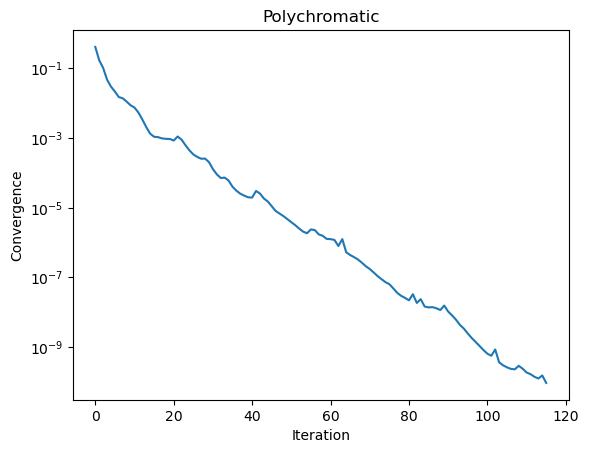

In [21]:
plt.plot(output['convergence'])
plt.title("Polychromatic")
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

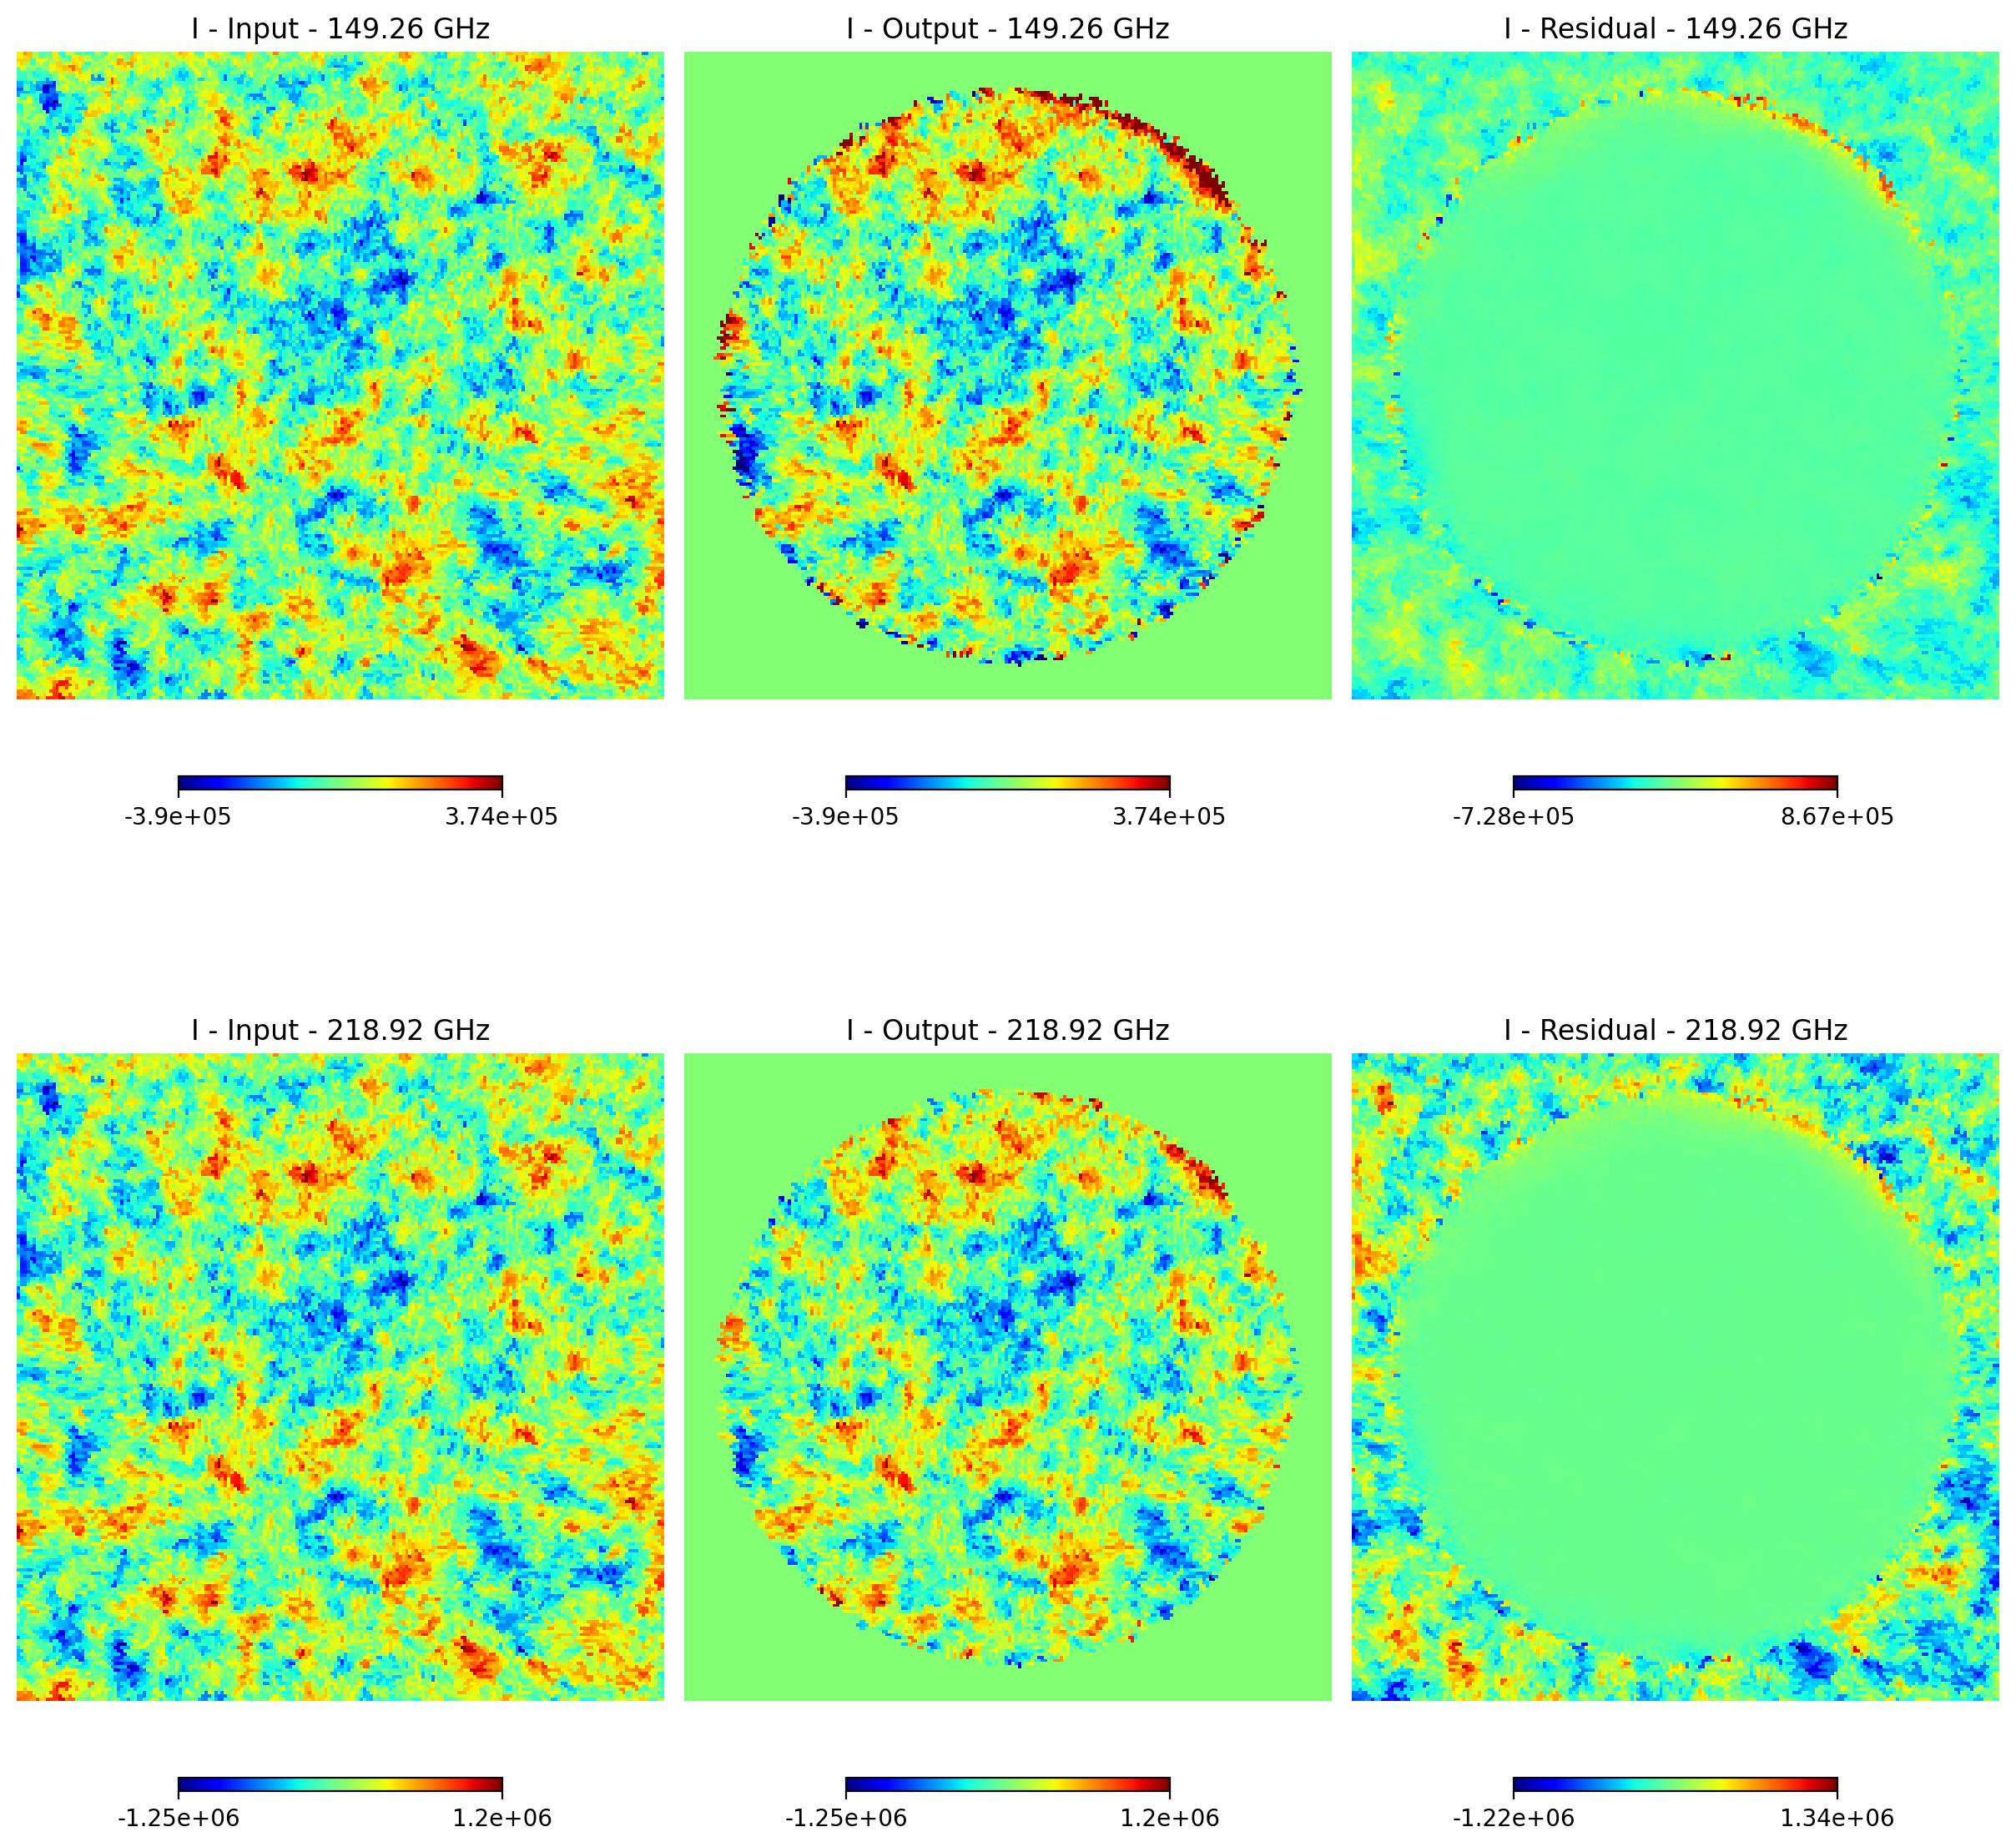

In [22]:
plt.figure(figsize=(12, 12), dpi=200)
k=1
# true_maps[:, ~seenpix, :] = hp.UNSEEN
# output['x'][:, ~seenpix, :] = hp.UNSEEN

stk = ['I', 'Q', 'U']
istk = 0
n_sig = 3
reso = 25

for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], min=np.min(true_maps[inu, seenpix, istk]), max=np.max(true_maps[inu, seenpix, istk]), cmap='jet', rot=qubic_patch,title='{} - Input - {:.2f} GHz'.format(stk[istk], true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k), notext=True)
    hp.gnomview(output['x'][inu, :, istk], min=np.min(true_maps[inu, seenpix, istk]), max=np.max(true_maps[inu, seenpix, istk]), cmap='jet', rot=qubic_patch,title='{} - Output - {:.2f} GHz'.format(stk[istk], true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k+1), notext=True)
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='{} - Residual - {:.2f} GHz'.format(stk[istk], true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k+2), notext=True)
    k+=3

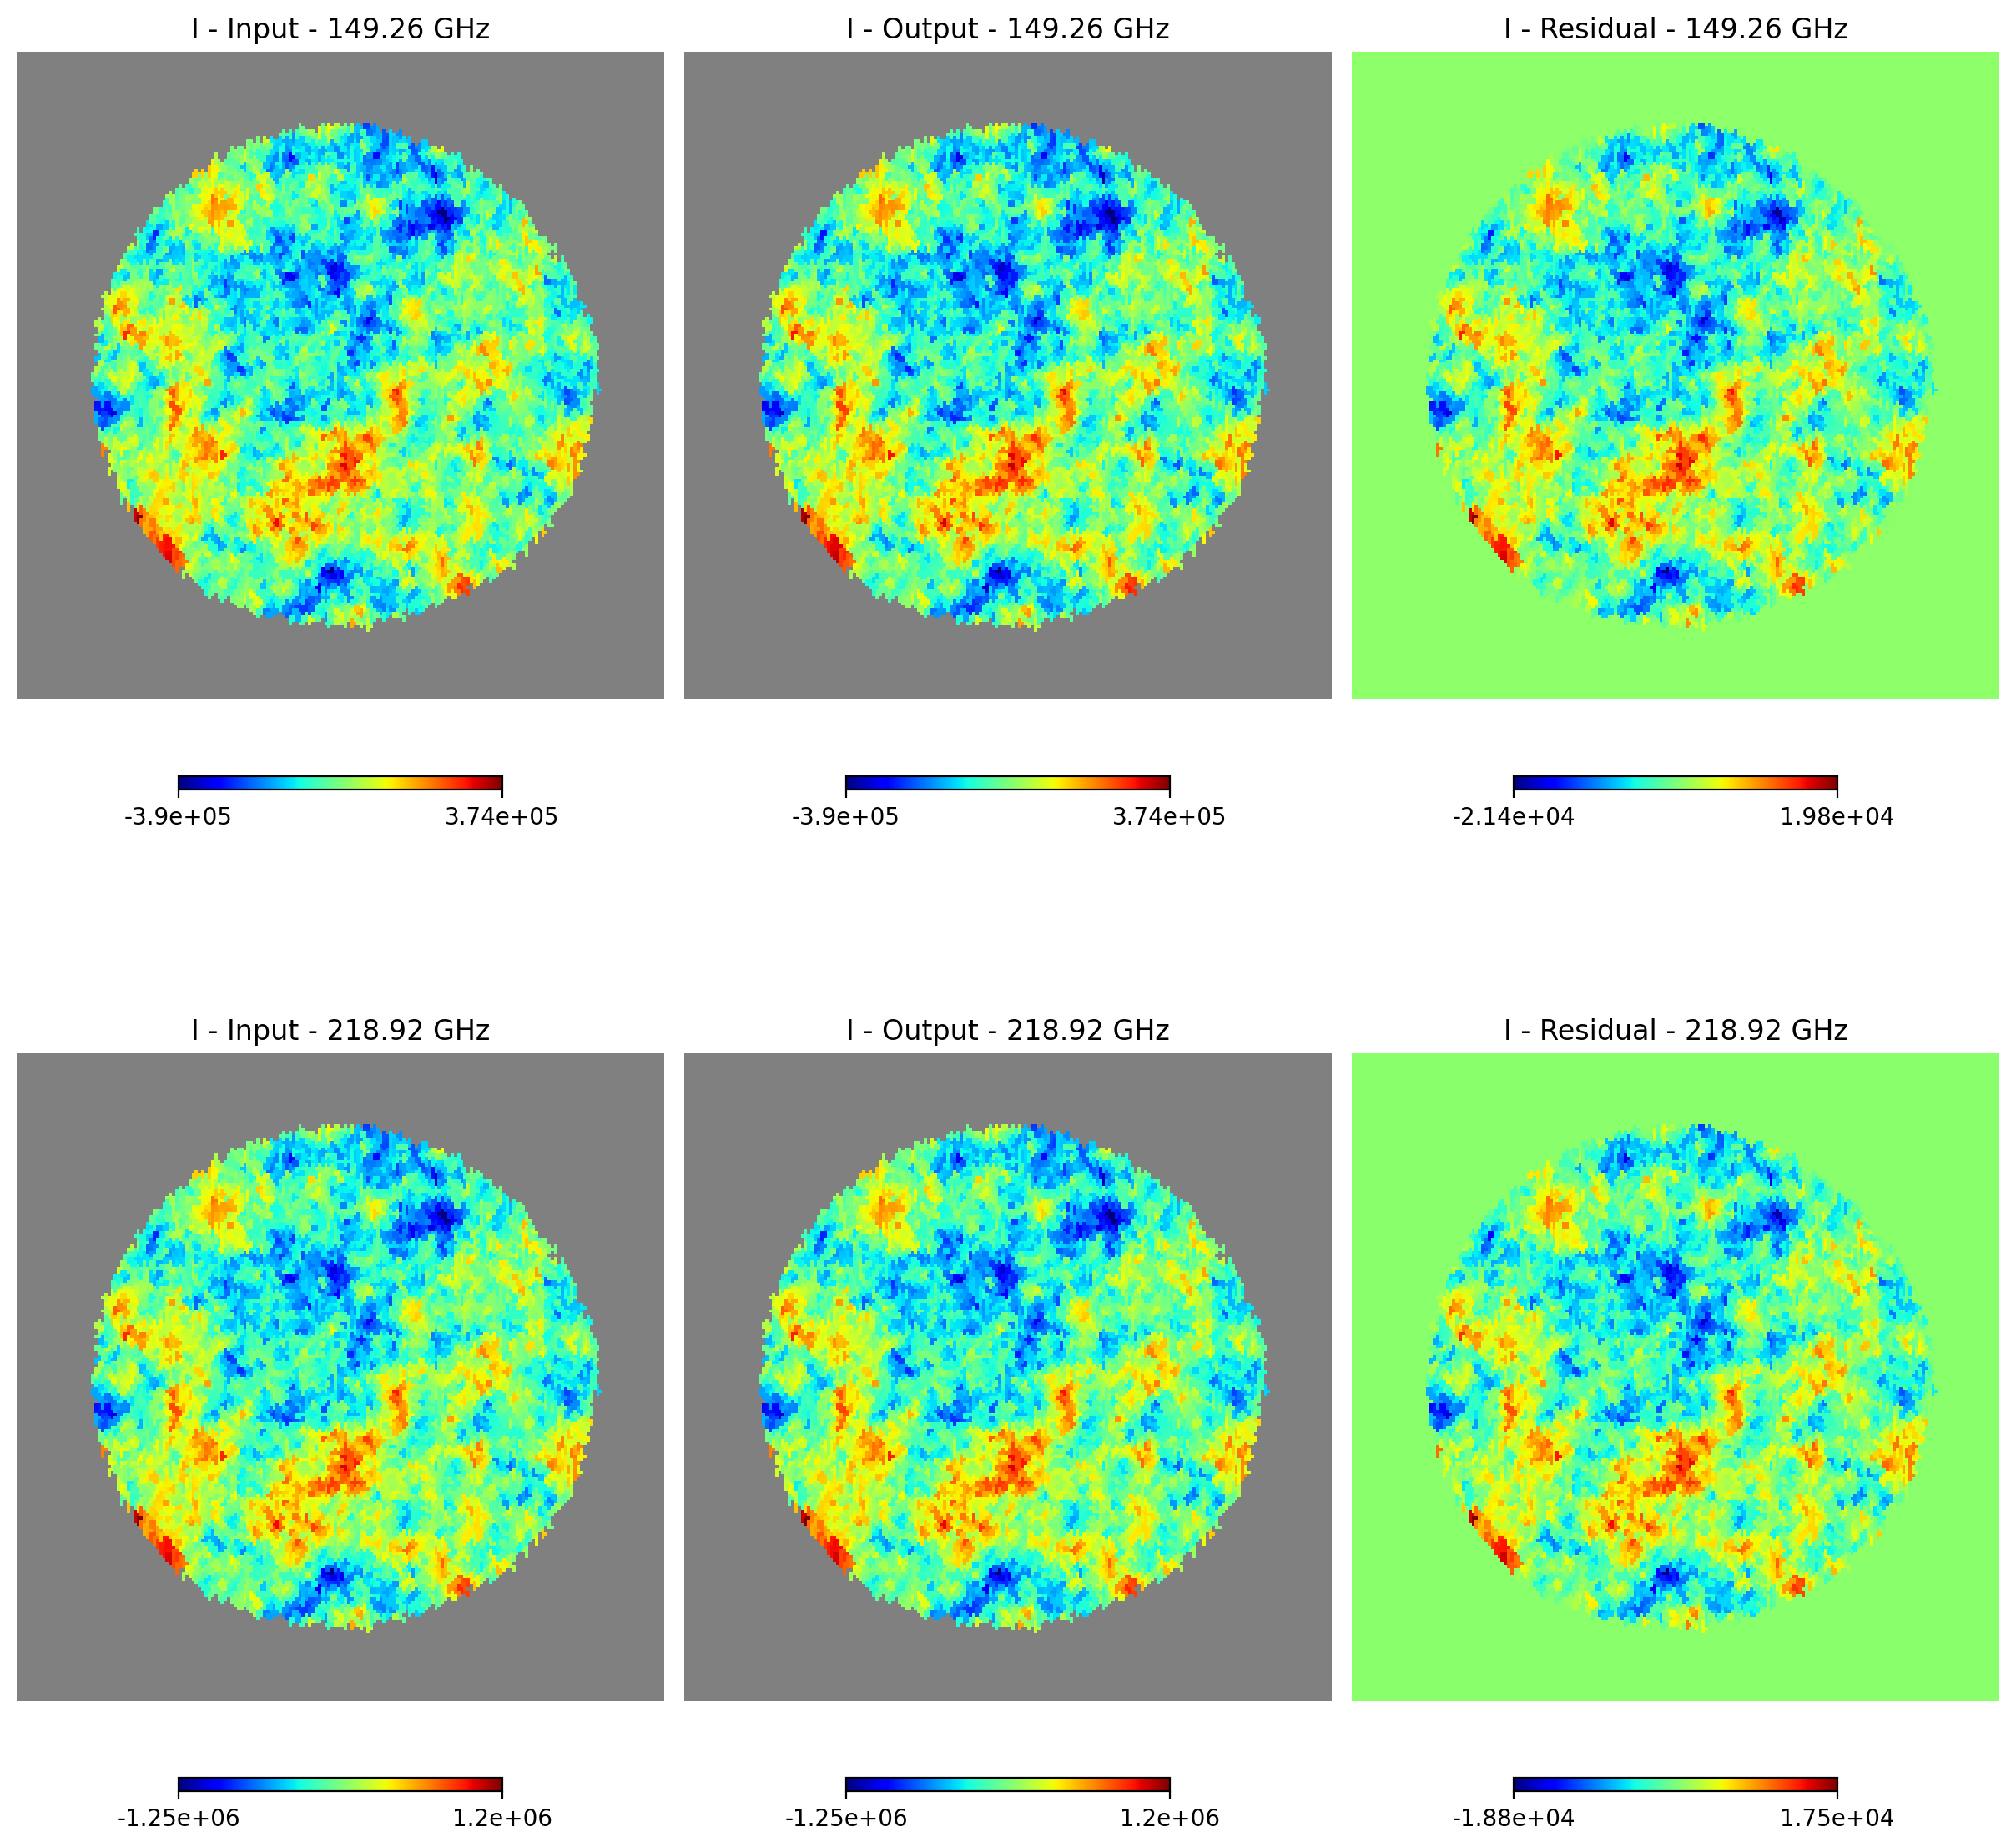

In [23]:
plt.figure(figsize=(12, 12), dpi=200)
k=1
true_maps[:, ~seenpix, :] = hp.UNSEEN
output['x'][:, ~seenpix, :] = hp.UNSEEN

stk = ['I', 'Q', 'U']
istk = 0
n_sig = 3
reso = 15

for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], min=np.min(true_maps[inu, seenpix, istk]), max=np.max(true_maps[inu, seenpix, istk]), cmap='jet', rot=qubic_patch,title='{} - Input - {:.2f} GHz'.format(stk[istk], true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k), notext=True)
    hp.gnomview(output['x'][inu, :, istk], min=np.min(true_maps[inu, seenpix, istk]), max=np.max(true_maps[inu, seenpix, istk]), cmap='jet', rot=qubic_patch,title='{} - Output - {:.2f} GHz'.format(stk[istk], true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k+1), notext=True)
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, 0], cmap='jet', rot=qubic_patch,title='{} - Residual - {:.2f} GHz'.format(stk[istk], true_frequencies[inu]), reso=reso, sub=(output['x'].shape[0], 3, k+2), notext=True)
    k+=3

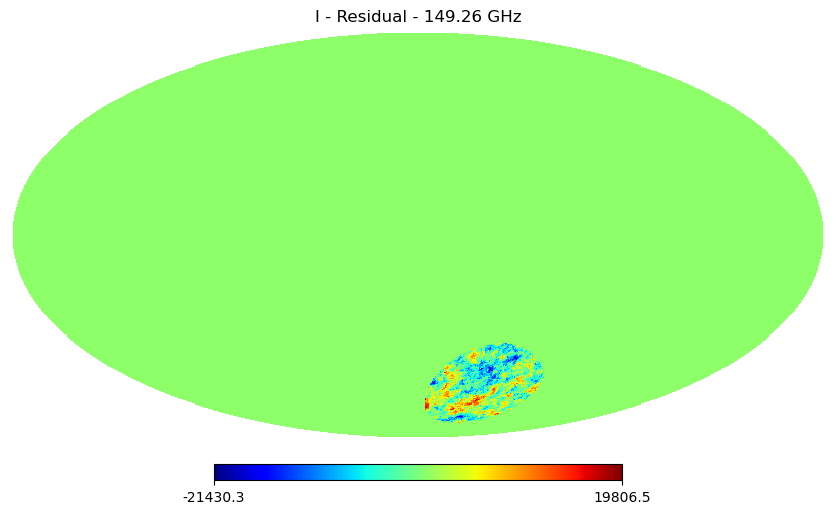

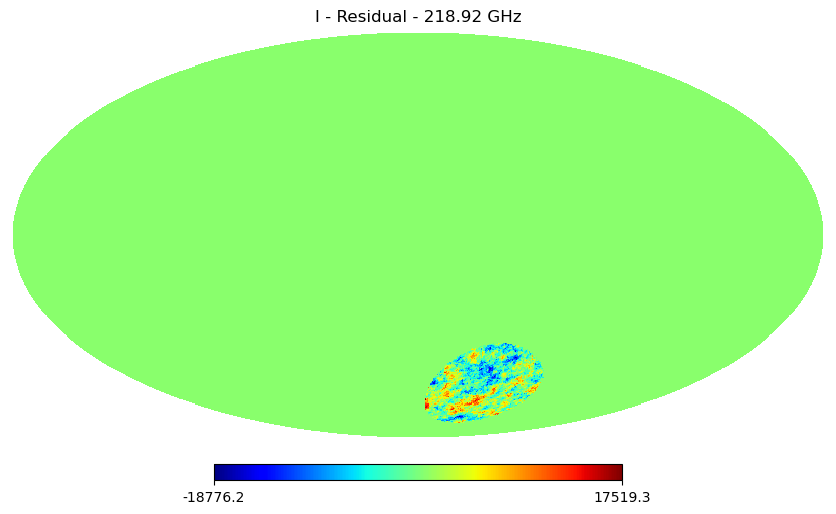

In [24]:
for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.mollview(output['x'][inu, :, istk] - true_maps[inu, :, istk], cmap='jet',title='{} - Residual - {:.2f} GHz'.format(stk[istk], true_frequencies[inu]))

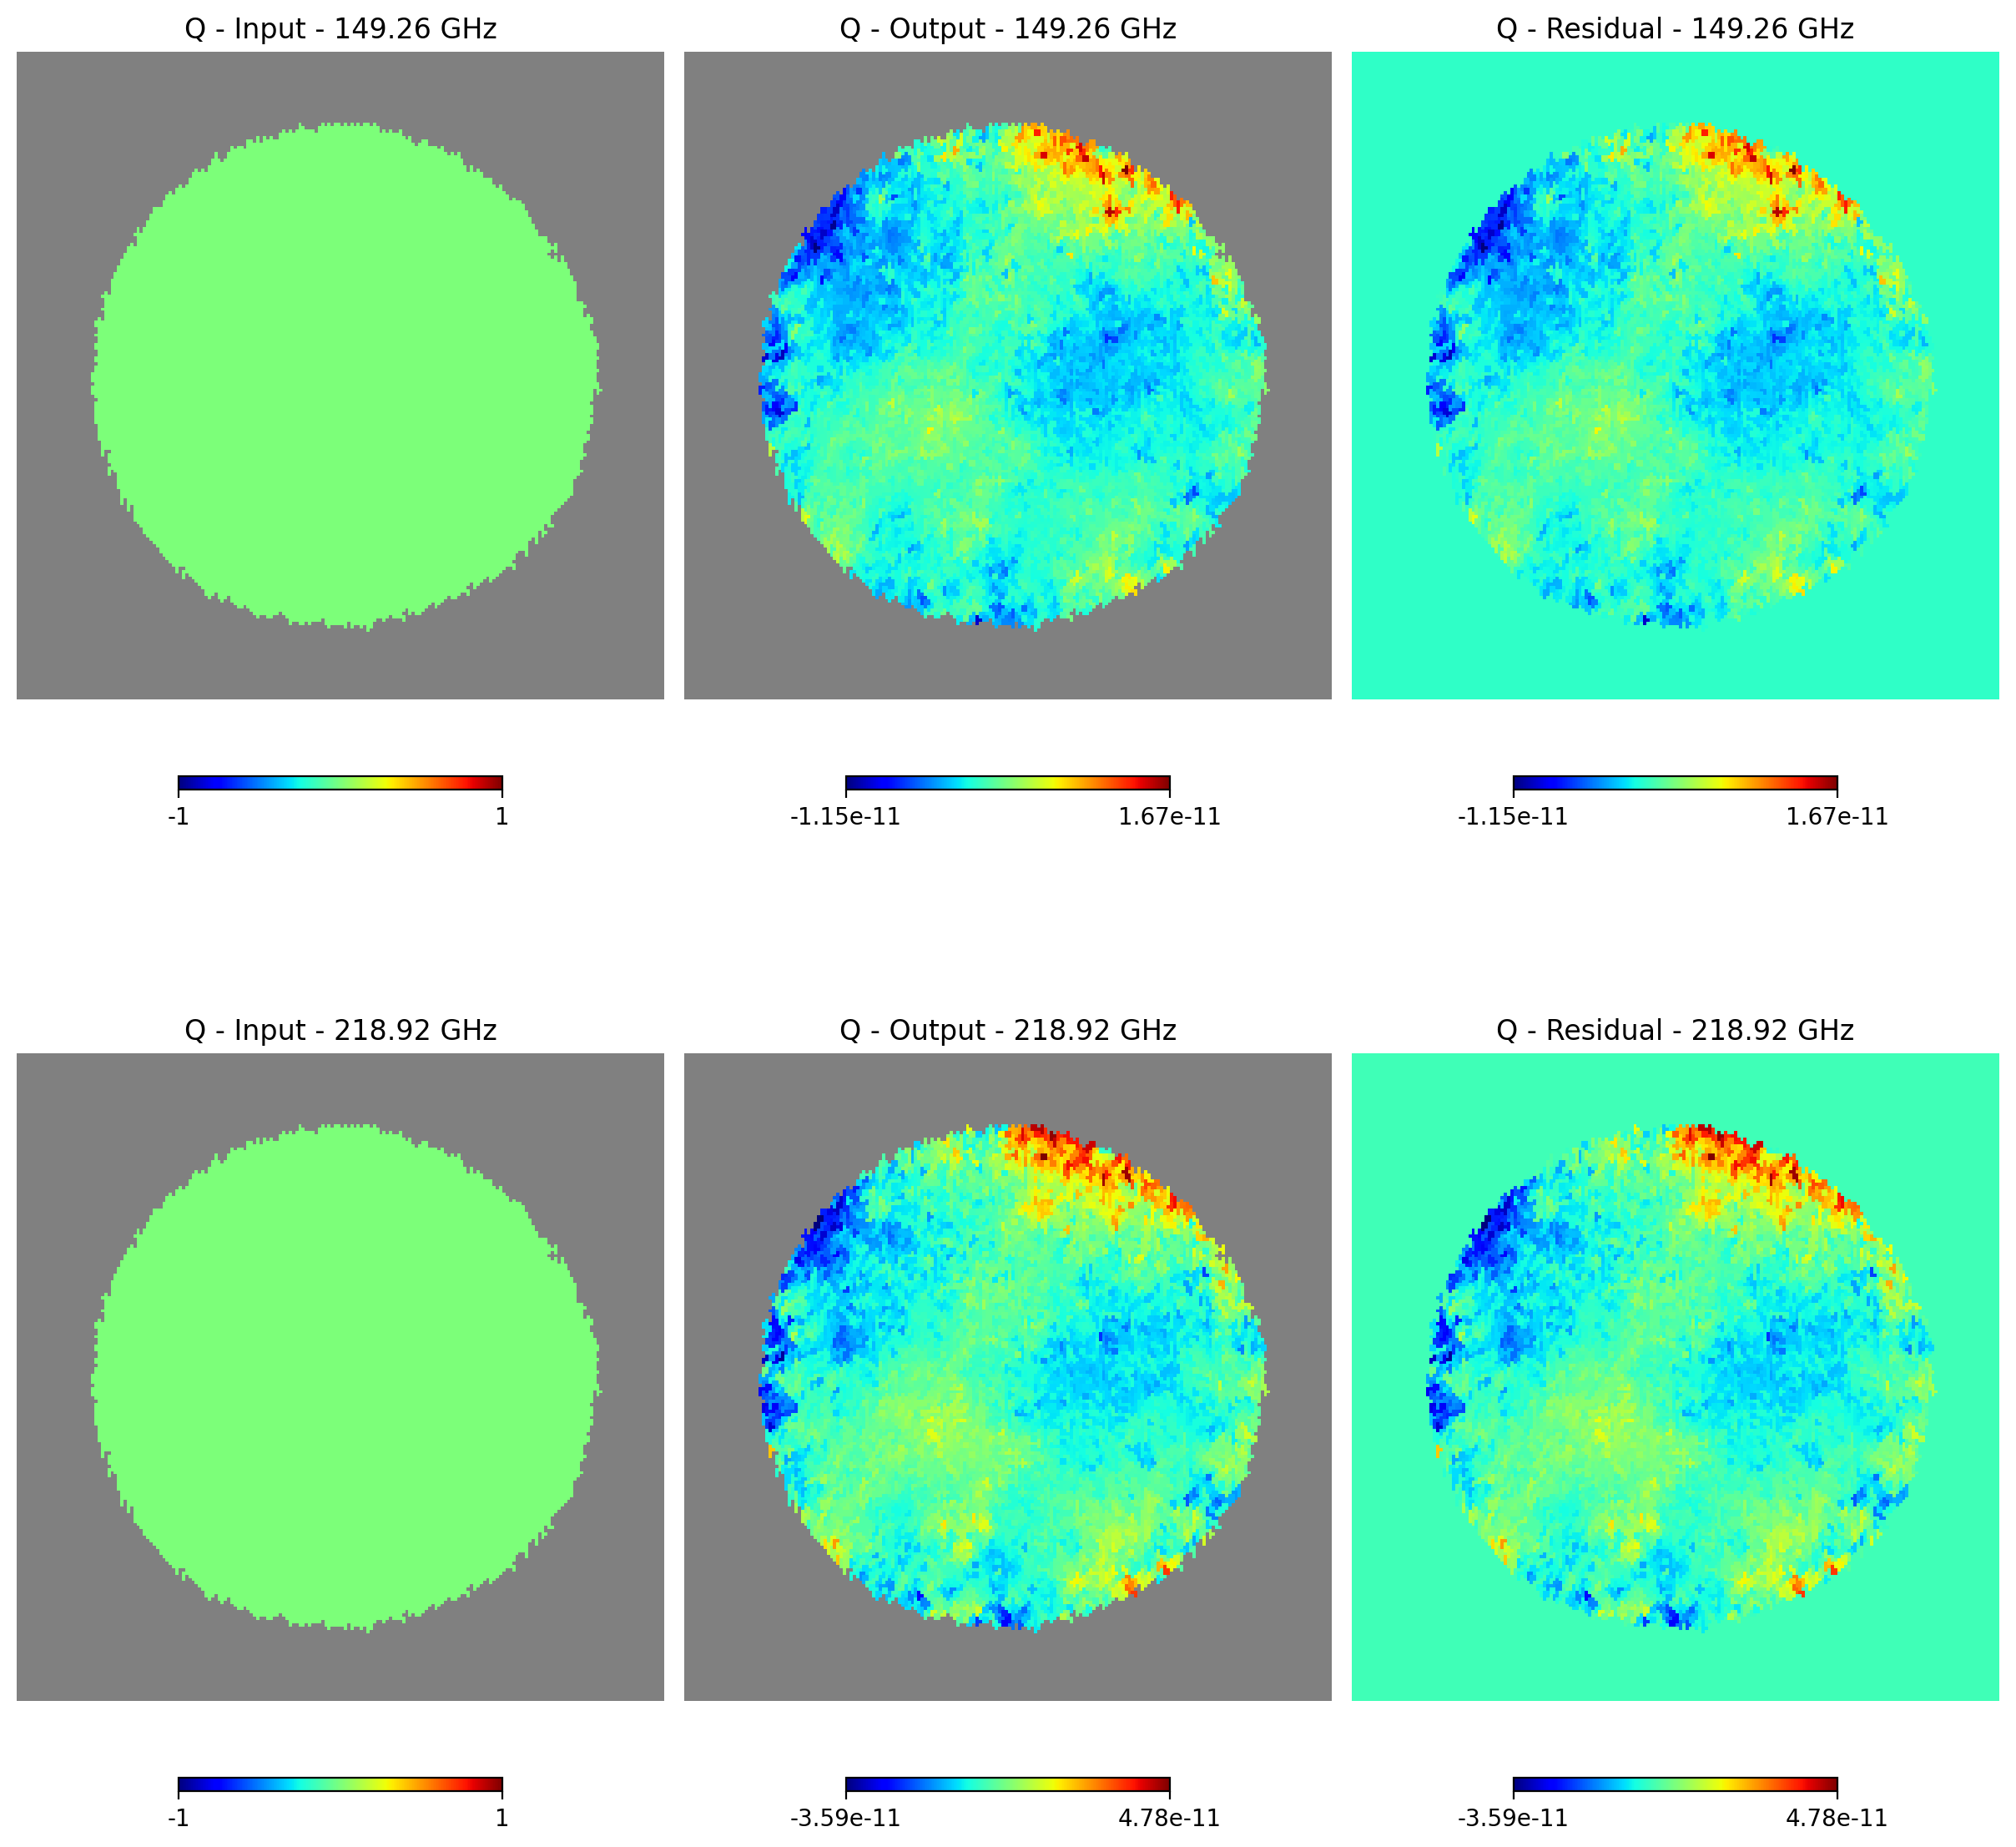

In [25]:
plt.figure(figsize=(12, 12), dpi=200)

k=1

istk = 1
n_sig = 2

for inu in range(output['x'].shape[0]):
    sigma = np.std(true_maps[inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='{} - Input - {:.2f} GHz'.format(stk[istk], true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k), notext=True)
    hp.gnomview(output['x'][inu, :, istk], cmap='jet', rot=qubic_patch,title='{} - Output - {:.2f} GHz'.format(stk[istk], true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+1), notext=True)
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='{} - Residual - {:.2f} GHz'.format(stk[istk], true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+2), notext=True)
    k+=3